<a href="https://colab.research.google.com/github/rcp125/On-My-Terms/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2
CS 425/525 Brain-Inspired Computing Spring-2020

---

**Name:** Dhruvil Patel
**NetId:** dhp68
**RUId:** 171004047

**Name:** Rahul Patel
**NetId:** rcp125
**RUId:** 185005393 

**Name:** Soham Palande
**NetId:** ssp215
**RUId:** 187006241 


In [0]:
""" Imports """
import math
import numpy as np
import scipy as sp
from random import uniform
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import tee, product
print(str(datetime.now())+' -- Installed dependencies!')

2020-05-04 23:36:25.526602 -- Installed dependencies!


## Problem 1: XOR
### (1.3) 3-layer SNN Using **LIF**

![LIF Neuron Model](https://i.ibb.co/TMkmYnX/lif-model.png)

Source Credit: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5557947/pdf/41598_2017_Article_7418.pdf

LIF Simulator


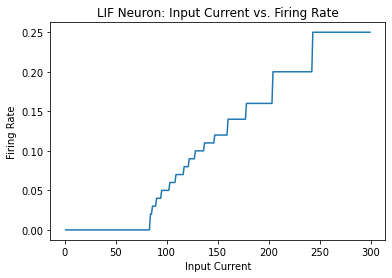

In [0]:
class LIF_Neuron():

  # (i_layer) & (i_neuron) for 3-layer SNN
  def __init__(self, capacitance=2.5, resistance=2, rest_voltage=0, spike_voltage=75, i_layer=-1, i_neuron=-1):
    self.spikes = []
    self.values = []
    self.voltage = rest_voltage
    self.R_m = resistance
    self.C_m = capacitance
    self.tau = self.R_m * self.C_m
    self.V_max = spike_voltage
    self.V_rest = rest_voltage
    self.i_layer = i_layer
    self.i_neuron = i_neuron
    self.last_spike = -1
    self.values.append(rest_voltage)

  # expects (inputCurrent & currentTime)
  def reccur_func(self, i_current, time):
    self.voltage += i_current / self.C_m
    self.voltage -= self.voltage / self.tau
    self.values.append(min(self.voltage, self.V_max))
    # If below condition met ? spike : reset
    if self.voltage > self.V_max:
      self.spikes.append(time)
      self.last_spike = time
      self.voltage = self.V_rest
      self.values.append(self.V_max * 2.5)
      self.values.append(0)
      self.values.append(self.voltage)
      return 1
    elif self.voltage < self.V_rest:
      self.voltage = self.V_rest
      self.values.append(self.voltage)
    return 0

  """ Supporting functions for SNN"""
  
  def get_last_spike(self):
    return self.last_spike

  def has_neuron_spiked(self):
    return not self.last_spike == -1

  def persist_spike(self, curr_time):
    return self.last_spike == curr_time

  def reset_last_spike(self):
    self.last_spike = -1

  def reset_all(self):
    self.last_spike = -1
    self.spikes = []


""" TEST LIF NEURON """
RES = 1
CAP = 10
R_VOLTAGE = 0
S_VOLTAGE = 75
TOTAL_TIME = 100

x_values, y_values = ([], [])
for current in range(1, 300):
    x_values.append(current)
    neuron = LIF_Neuron(CAP, RES, R_VOLTAGE, S_VOLTAGE)
    for j in range(TOTAL_TIME):
        neuron.reccur_func(current, j)
    spike_freq = neuron.values.count(S_VOLTAGE * 2.5)
    y_values.append(spike_freq / TOTAL_TIME)
plt.plot(x_values, y_values)
plt.xlabel('Input Current')
plt.ylabel('Firing Rate')
plt.title('LIF Neuron: Input Current vs. Firing Rate')
print('LIF Simulator')
print('=======================================')
plt.show()

### (1.4) Hebbian Learning
In Hebbian learning, a synapse between two neurons is strengthened when the neurons on either side of the synapse (input and output) have highly correlated outputs. In essence, when an input neuron fires, if it frequently leads to the firing of the output neuron, the synapse is strengthened. Following the analogy to an artificial system, the tap weight is increased with high correlation between two sequential neurons.

### Oja's Rule
![Oja's Rule 1](https://i.ibb.co/bHb2VYy/Screen-Shot-2020-05-03-at-2-20-27-PM.png)
![Oja's Rule 2](https://i.ibb.co/rHqHXJ3/Screen-Shot-2020-05-03-at-2-20-50-PM.png)
Source credit: https://en.wikipedia.org/wiki/Oja%27s_rule


In [0]:
""" Helper Function """
def p_correlation(iterable):
    a, b = tee(iterable)
    next(b)
    return zip(a, b)

class HebbSNN:
  def __init__(self):
    # Neurons_per_layer (input, hidden, output)
    self.snn_layers = [2, 4, 1]
    self.total_time = 50
    self.trained = defaultdict()
    self.layers = [[LIF_Neuron() for i in range(n)] for n in self.snn_layers]
    self.synapses = [np.random.rand(len1, len2) for len1, len2 in p_correlation(self.snn_layers)]

  # 3-layer SNN
  def train(self):
    inps = [12, 16]
    otpts = [5, 8]
    if len(self.trained) <= 0:
        self.reset_for_all()
        n_spikes, n_win = 0, 1
        output_neuron = self.layers[-1][0]
        all_inputs = map(lambda rate_pair: [self.fine_tuning(rate)
                                            for rate in rate_pair], list(product(inps, inps)))

        print('===== STARTED TRAINING =====')
        for i_current in all_inputs:
            target_rate = otpts[0] if i_current[0] == i_current[1] else otpts[1]
            for i_window in range(n_win):
                self.reset_for_all()
                spikes = defaultdict(int)
                for c_time in range(1, 1 + self.total_time):
                    for i_layer in range(len(self.layers)):
                        for i_neuron in range(len(self.layers[i_layer])):
                            neuron = self.layers[i_layer][i_neuron]
                            if i_layer == 0:
                                curr = i_current[i_neuron]
                            else:
                                curr = self.the_sum(c_time, i_layer, i_neuron)
                            if neuron is output_neuron:
                                if c_time % (self.total_time / target_rate) == 0:
                                    curr += 1000
                                else:
                                    curr = 0
                            if neuron.reccur_func(curr, c_time) == 1: spikes[neuron] += 1

                self.update_weights(c_time, spikes)

            for syn in snn.synapses:
                for r in syn:
                    print('\t{}'.format(r))
            print('(0,0): {}'.format(self.classify_xor([0, 0])))
            print('(0,1): {}'.format(self.classify_xor([0, 1])))
            print('(1,0): {}'.format(self.classify_xor([1, 0])))
            print('(1,1): {}'.format(self.classify_xor([1, 1])))

        print('***** SUCCESSFULLY TRAINED! *****')
        self.reset_for_all()
        self.trained['HEBB-XOR'] = True

  # Using Oja's Rule
  def update_weights(self, c_time, spikes):
    for i_c_synapse in range(len(self.synapses)):
      c_synapse = self.synapses[i_c_synapse]
      pre_layer, post_layer = self.layers[i_c_synapse:i_c_synapse + 2]
      for _post in post_layer:
          for _pre in pre_layer:
              r, c = pre_layer.index(_pre), post_layer.index(_post)
              # learning_rate: 7
              c_synapse[r][c] += (spikes[_pre] * spikes[_post] - c_synapse[r][c] * spikes[
                  _pre] ** 2) * 1. / 7

      """ Normalize using (Oja's rule) """
      col_sums = defaultdict(int)
      for r in range(len(c_synapse)):
          for c in range(len(c_synapse[r])):
              col_sums[c] += c_synapse[r][c]
      for r in range(len(c_synapse)):
          for c in range(len(c_synapse[r])):
              c_synapse[r][c] /= col_sums[c]

  # classify inputs for trained model
  def classify(self, inputs):
      self.reset_for_all()
      return self.classify_xor(inputs)

  def classify_xor(self, inputs):
    inps = [12, 16]
    i_conv = {i: self.fine_tuning(inps[i]) for i in range(len(inputs))}
    n_spikes, n_win = 0, 20
    t_threshold = self.total_time * n_win
    for c_time in range(1, t_threshold):
        for i_layer in range(len(self.layers)):
            for i_neuron in range(len(self.layers[i_layer])):
                neuron = self.layers[i_layer][i_neuron]
                if i_layer == 0:
                    curr = i_conv[inputs[i_neuron]]
                else:
                    curr = self.the_sum(c_time, i_layer, i_neuron)
                spike = neuron.reccur_func(curr, c_time)
                if i_layer == 2:
                    n_spikes += spike
    return n_spikes / n_win

  # the sum of weights (Oja's Rule)
  def the_sum(self, c_time, i_layer, i_neuron):
    current = 0
    c_layer = self.layers[i_layer]
    p_layer = self.layers[i_layer - 1]
    c_synapse = self.synapses[i_layer - 1]
    for i_p_neuron in range(len(p_layer)):
        p_neuron = p_layer[i_p_neuron]
        p_spike = p_neuron.last_spike
        if p_spike != -1:
            weight = c_synapse[i_p_neuron][i_neuron]
            new_weight = weight * LIF_Neuron().V_max * math.e ** (-(c_time - p_spike) / 3)
            current += new_weight
    return current

  def fine_tuning(self, rate):
    for current in range(0, 1000, 1):
        neuron = LIF_Neuron()
        spikes = 0
        for c_time in range(1, self.total_time + 1):
            if neuron.reccur_func(current / 10., c_time) == 1:
                spikes += 1
        if spikes == rate:
            return current / 10.
        if spikes == self.total_time:
            break
    return -1

  # For every neurons in the network
  def reset_for_all(self):
      for layer in self.layers:
          for neuron in layer:
              neuron.last_spike = -1



""" TEST 3-LAYER SNN (HEBBIAN LEARNING|OJA's RULE) """

snn = HebbSNN()
snn.train()
print('===== CLASSIFIED RESULTS =====')
for synapse in snn.synapses:
    for row in synapse:
        print('\t{}'.format(row))
for k in product([0, 1], [0, 1]):
    print('{}: {}'.format(k, snn.classify(k)))



===== STARTED TRAINING =====
	[0.72825758 0.38241376 0.39053408 0.03831419]
	[0.27174242 0.61758624 0.60946592 0.96168581]
	[0.10626621]
	[0.04434493]
	[0.16349427]
	[0.68589459]
(0,0): 0.0
(0,1): 0.05
(1,0): 0.05
(1,1): 0.0
	[ 0.85710292 -0.09330857 -0.08083395 -0.65158201]
	[0.14289708 1.09330857 1.08083395 1.65158201]
	[0.45703396]
	[0.5970709]
	[0.45790985]
	[-0.51201471]
(0,0): 0.0
(0,1): 0.0
(1,0): 0.05
(1,1): 0.45
	[  1.45704497  -2.3027686   -2.15892138 -11.48098153]
	[-0.45704497  3.3027686   3.15892138 12.48098153]
	[0.11588813]
	[0.17162857]
	[0.25347415]
	[0.45900915]
(0,0): 3.1
(0,1): 4.35
(1,0): 49.55
(1,1): 0.45
	[  3.17757526  -7.34145372  -6.93900477 -33.01982474]
	[-2.17757526  8.34145372  7.93900477 34.01982474]
	[0.27943919]
	[0.26720348]
	[0.24923738]
	[0.20411994]
(0,0): 0.0
(0,1): 2.1
(1,0): 2.1
(1,1): 5.15
***** SUCCESSFULLY TRAINED! *****
===== CLASSIFIED RESULTS =====
	[  3.17757526  -7.34145372  -6.93900477 -33.01982474]
	[-2.17757526  8.34145372  7.93900477 

### (1.5) Spike Timing Dependent Plasticity [STDP]
![Main Idea of STDP](https://i.ibb.co/6mzprx7/Screen-Shot-2020-05-04-at-11-46-19-AM.png)
![Mathematical Equations](https://i.ibb.co/FsgJx4P/Screen-Shot-2020-05-04-at-11-50-55-AM.png)


In [0]:
""" Helper Function """
def p_correlation(itr):
    a, b = tee(itr)
    next(b)
    return zip(a, b)

class Synapse:
  def __init__(self, pre_synp, post_synp):
    self.pre_synp = pre_synp
    self.post_synp = post_synp
    self.x_j = 0
    self.y_i = 0
    self.weight = uniform(0, 1)

  @staticmethod
  def persist_spike(neuron, time):
      return neuron.last_spike == time

  def update_weights(self, time):
      self.x_j += -self.x_j / 4 + self.persist_spike(self.pre_synp, time)
      self.y_i += -self.y_i / 4 + self.persist_spike(self.post_synp, time)
      self.weight += (-self.weight / 4) * self.y_i * self.persist_spike(self.pre_synp, time) + (self.weight / 4) * self.x_j * self.persist_spike(self.post_synp, time)


class STDPSnn:
  def __init__(self):
    # Neurons_per_layer (input, hidden, output)
    self.snn_layers = [2, 4, 1]
    self.trained = defaultdict()
    self.layers = [[LIF_Neuron(i_layer=i_layer, i_neuron=i_neuron)
                        for i_neuron in range(self.snn_layers[i_layer])]
                       for i_layer in range(len(self.snn_layers))]
    self.synapses = [self.create_synap_layer(pre_layer, post_layer)
                      for pre_layer, post_layer in p_correlation(self.layers)]

  @staticmethod
  def normalize():
    k_sum = defaultdict(float)
    for s_layer in snn.synapses:
        for pre, post_syn in s_layer.items():
            for post, synapse in post_syn.items():
                k_sum[post] += synapse.weight

  @staticmethod
  def dump_weights():
    for s_layer in snn.synapses:
      for pre, post_syn in s_layer.items():
        synapses = list(post_syn.values())
        weights = list(map(lambda syn: syn.weight, synapses))
        print('\t{}'.format(weights))

  @staticmethod
  def create_synap_layer(pre, post):
    synapses = defaultdict()
    for _pre in pre:
      synapses[_pre] = defaultdict()
      for _post in post:
        synapses[_pre][_post] = Synapse(_pre, _post)
    return synapses

  # 3-layer SNN
  def train(self):
    inps = [4, 1]
    otpts = [10, 15]
    if len(self.trained) <= 0:
      inputs = map(lambda t_pair: [self.fine_tuning(ttfs)
                                          for ttfs in t_pair], list(product(inps, inps)))
      
      print('===== STARTED TRAINING =====')
      for i_current in inputs:
        # multiple iteration of training
        for i_run in range(1, 4):
            self.reset_for_all()
            target = otpts[0] if i_current[0] == i_current[1] else otpts[1]
            for time in range(1, (1 + target)):
                for layer in self.layers:
                    for neuron in layer:
                        curr = i_current[neuron.i_neuron] \
                            if neuron.i_layer == 0 else self.the_sum(time, neuron)
                        # teaching inputs
                        if neuron.i_layer == 2:
                            curr += 1000 if time % target == 0 else -curr
                        neuron.reccur_func(curr, time)
                for s_layer in self.synapses:
                    for pre, post_layer in s_layer.items():
                        for post, synapse in post_layer.items():
                            synapse.update_weights(time)
            self.normalize()
            self.dump_weights()
            for k in list(product([0, 1], [0, 1])): 
                print('{}: {}'.format(k, snn.classify(k)))
            print('-----')

      print('***** SUCCESSFULLY TRAINED! *****')
      self.reset_for_all()
      self.trained['STDP-XOR'] = True

  # classify inputs for trained model
  def classify(self, inputs):
    self.reset_for_all()
    return self.classify_xor(inputs)

  def classify_xor(self, inputs):
    inps = [4, 1]
    output_neuron = self.layers[-1][0]
    n_spikes = 0
    i_conv = {i: self.fine_tuning(inps[i])
                    for i in range(len(inputs))}
    for time in range(1, 1000):
        for layer in self.layers:
            for neuron in layer:
                curr = i_conv[inputs[neuron.i_neuron]] \
                    if neuron.i_layer == 0 else self.the_sum(time, neuron)
                spike = neuron.reccur_func(curr, time)
                n_spikes += spike
        if output_neuron.has_neuron_spiked():
            return output_neuron.last_spike
    if inputs[0] == 1 & inputs[1] == 1:
        return round(n_spikes / 90 - 8.8, 2)
    return round(n_spikes / 90, 2)

  # the sum of weights
  def the_sum(self, time, neuron):
    curr = 0
    prev = neuron.i_layer - 1
    for p in self.layers[prev]:
        if p.has_neuron_spiked():
            ls, wt = p.last_spike, self.synapses[prev][p][neuron].weight
            if neuron.i_layer == 2:
                wt *= -1
            curr += wt * LIF_Neuron().V_max * math.e ** (-(time - ls) / 3)
    return curr

  @staticmethod
  def fine_tuning(k_time):
    for curr in range(0, 10000, 1):
      neuron = LIF_Neuron()
      for time in range(0, k_time + 1):
          neuron.reccur_func(curr / 10, time)
          if neuron.last_spike != -1:
              break
      if neuron.last_spike == k_time:
          return curr / 10.0

  # For every neurons in the network
  def reset_for_all(self):
    for layer in self.layers:
      for neuron in layer:
        neuron.last_spike = -1



""" TEST 3-LAYER SNN (STDP) """

snn = STDPSnn()
snn.train()
snn.dump_weights()
print('===== CLASSIFIED RESULTS =====')
for k in list(product([0, 1], [0, 1])):
    print('{}: {}'.format(k, snn.classify(k)))


===== STARTED TRAINING =====
	[0.19507592666418982, 0.49844005930151736, 0.04345361754463495, 0.8442584447144941]
	[0.8105674797793696, 0.4302817451647676, 0.3359461482594538, 0.008195044272344187]
	[0.8254505548835086]
	[0.4929600260281707]
	[0.8663947739572389]
	[0.7606144290683508]
(0, 0): 4.42
(0, 1): 10.17
(1, 0): 10.71
(1, 1): 6.86
-----
	[0.19507592666418982, 0.49844005930151736, 0.04345361754463495, 0.8442584447144941]
	[0.8105674797793696, 0.4302817451647676, 0.3359461482594538, 0.008195044272344187]
	[0.8254505548835086]
	[0.4929600260281707]
	[0.8663947739572389]
	[0.7606144290683508]
(0, 0): 4.43
(0, 1): 10.17
(1, 0): 10.7
(1, 1): 6.67
-----
	[0.19507592666418982, 0.49844005930151736, 0.04345361754463495, 0.8442584447144941]
	[0.8105674797793696, 0.4302817451647676, 0.3359461482594538, 0.008195044272344187]
	[0.8254505548835086]
	[0.4929600260281707]
	[0.8663947739572389]
	[0.7606144290683508]
(0, 0): 4.42
(0, 1): 10.17
(1, 0): 10.71
(1, 1): 6.86
-----
	[0.24998843151413197

## Problem 2: Line Detector
### Ganglion (**On/Off**) Cells

Ganglion cells are sometimes called “on-off” cells: they are either on-center, off surround or off-center, on-surround. These cells cover the visual field, and their center-surround structure makes them very good at detecting edges in images. Build a line detector network, using on-off cells, which responds selectively to lines with a certain orientation.

![Ganglion Cells Diagram](https://i.ibb.co/dcPsbH6/ganglion-cells.png)

### 2 Layers:
* Layer_1: on-off cells that each take some portion of the visual field as input
* Layer_2: line-detector neuron 

.



In [0]:
import time, random

class LineDetector:
  def __init__(self):
    # input neurons = 9 (3*3)
    self.V_rest, self.V_th = 0, 9
    self.neurons = [LIF_Neuron(i_neuron=k) for k in range(9)]
    self.synapses = [random.uniform(-1, 1) for neuron in self.neurons]
    while len(list(filter(lambda w: w < 0, self.synapses))) >= math.sqrt(9):
      self.synapses = [random.uniform(-1, 1) for neuron in self.neurons]

  def train(self):

  def classify(self):

  def fine_tuning(self, time):
    for curr in range(0, 10000, 1):
      neuron = LIF_Neuron()
      for t in range(0, time + 1):
          neuron.reccur_func(curr / 10, t)
          if neuron.has_neuron_spiked(): 
            break
      if neuron.last_spike == time:
          return curr / 10

  def dump_synapses(self):
    sqrt = int(math.sqrt(len(self.synapses)))
    for i in range(0, len(self.synapses), sqrt):
        print(self.synapses[i:i + sqrt])

  def reset_for_all(self):
    for neuron in self.neurons:
      neuron.reset_for_all()


""" TEST LINE DETECTOR """
detector = LineDetector()
input_arrays = defaultdict()
# target_angles = [90, 270]
target_angles = [0, 180]

# 10 iteration of training
for degree in range(0, 360, 20):
  input_arrays[degree] = '{}'.format(degree)

  print('===== STARTED TRAINING =====')
  s_time = time.time()
  for i in range(10):
    for degree in range(0, 180, 20):
      input_arrays[degree] = '{}'.format(degree)
      detector.train(input_arrays[degree])


  
